In [1]:
using PyPlot
using Seaborn
import JLD2
import Distributions

In [13]:
include("src\\NGSIM.jl")

# td = load_trajdata(1);
JLD2.@load "td.jld" td
rd = NGSIM.ROADWAY_101

(S, id_lookup) = td_sparse(td)
;

In [14]:
fs = [
    s::VehicleState -> s.v * cos(s.posF.ϕ), 
    s::VehicleState -> s.v * sin(s.posF.ϕ),
    s::VehicleState -> length(rd[s.posF.roadind.tag.segment].lanes) - s.posF.roadind.tag.lane + 1
]

T = min(10_000, nnz(S))

Y = AF64(length(fs), T)

for t in 1:T
    s = S.nzval[t]
    for (i, f) in fs |> enumerate
        @inbounds Y[i, t] = f(s)
    end
end

In [15]:
# the continuous data
YΓ = view(Y, 1:2, :)
NΓ = size(YΓ, 1)

# the discrete data (Int to use as indexing)
YΔ = round.(Int, Y[3, :])
NΔ = size(YΔ, 1)
;

In [49]:
#
# HMM Init
#

K = 5 # number states
M = 3 # number gaussian mixtures per state

# dimension of obs
N = NΓ + NΔ

# number of discrete observation states
# should only be 6 lanes in the data (but just in case)
L = 7

#
# transition parameters
#

# transition matrix; logs to avoid numberical underflow
# dirichlet returns distributions as the columns
A = rand(Dirichlet(K, 1), K)

# initial
π0 = rand(Dirichlet(K, 1))

#
# emission parameters
#

# bΔ[l, k] = P(yₜ = l | xₜ = k) (rows sum to 1)
# only for NΔ = 1; should be [rand(...)' for _ in 1:MΔ]
bΔ = rand(Dirichlet(L, 1), K)

# mixuter parameters for each MV per state
# c[m, k] is weight of m-th gaussian in for k-th state
c = rand(Dirichlet(M, 1), K)

# μs[:, m, k] is the mean of m-th mixture of the k-th state
μs = randn(NΓ, M, K) .+ squeeze(mean(YΓ, 2), 2)

# Σs[:, :, m, k] is the covariance of m-th mixture of the k-th state
Σs = repeat(cov(YΓ, 2), outer=(1, 1, M, K))
;

In [50]:
# number of trajectories
E = S.n

log_A = log.(A)
log_π0 = log.(π0)
log_bΔ = log.(bΔ)
log_c = log.(c)

invΣs = similar(Σs)
logdetΣs = similar(Σs, M, K)

for m in 1:M
    for k in 1:K
        invΣs[:, :, m, k] = inv(Σs[:, :, m, k])
        logdetΣs[m, k] = logdet(Σs[:, :, m, k])
    end
end

# log P(y₁, ..., yₜ, xₜ | θ)
log_α = AF64(K, T)
# log P(yₜ₊₁, ..., y_T | xₜ =i, θ)
log_β = AF64(K, T)

# log P(yₜ | xₜ, θ)
log_b = similar(log_α)

# P(xₜ = j | Y, θ)
γ = AF64(K, T)
# P(Xₜ = j, Zⱼₜ = m| Y, θ) = prob of state j, and m-th mixture at t
γ_mix = AF64(M, K, T)
# P(xₜ = j, xₙ₋₁ = i | Y, θ)
ξ = AF64(K, K, T)
;

In [51]:
@inline function log_bΓ(m::Int, k::Int, t::Int)
    o = AF64(NΓ)
    lpdf::Float64 = 0.0

    # shamelessly stolen from Distributions.jl/src/multivariate/mvnormal.jl
    lpdf = -(NΓ * log2π  + logdetΣs[m, k])/2
    o = YΓ[:, t] - μs[:, m, k]
    lpdf -= dot(o, (invΣs[:, :, m, k] * o)) / 2
    
    return lpdf
end

log_bΓ (generic function with 2 methods)

In [52]:
const NUM_ITER = 30
@time for iter in 1:NUM_ITER

    #
    # data likelihood
    #

    # log_b[t, i] =  p(Yₜ = yₜ | Xₜ = i) = p(YΓₜ = yₜ | Xₜ = i) * p(YΔₜ = yₜ | Xₜ = i)
    lgmm = AF64(M) # log of sum of GMM pdf

    @inbounds for t = 1:T
        for k in 1:K # per state
            lgmm[:] = log_c[:, k]
            for m in 1:M # per mixture
                lgmm[m] += log_bΓ(m, k, t)
            end

            log_b[k, t] = logsumexp(lgmm)
        end

        log_b[:, t] .+= log_bΔ[YΔ[t], :]
    end
    sanitize_log!(log_b)
    
    #
    # baum-welch
    # 

    # [ log_a[i, t-1] + log_A[j, i] ]ᵢ
    temp = AF64(K)

    log_α[:, 1] = log_π0 .+ log_b[:, 1]
    @inbounds for t in 2:T
        for j in 1:K
            temp[:] = log_α[:, t-1] 
            temp .+= log_A[j, :]
            log_α[j, t] = logsumexp(temp) + log_b[j, t]
        end
    end

    # backward pass
    # temp is [ log_A[j, i] + log_β[j, t+1] + log_b[j, t+1] ]ⱼ

    log_β[:, T] = 0
    @inbounds for t = (T-1):-1:1
        for i in 1:K
            temp[:] = log_A[:, i] 
            temp .+= log_b[:, t+1] 
            temp .+= log_β[:, t+1]
            log_β[i, t] = logsumexp(temp)
        end
    end

    @inbounds for t in 1:T
        γ[:, t] = log_α[:, t] 
        γ[:, t] .+= log_β[:, t]
        γ[:, t] .-= logsumexp(γ[:, t])
    end
    map!(exp, γ, γ)
    sanitize!(γ)

    @inbounds for t = 1:(T-1)
        ξ[:, :, t] = log_A
        ξ[:, :, t] .+= log_α[:, t]'
        ξ[:, :, t] .+= log_b[:, t+1]
        ξ[:, :, t] .+= log_β[:, t+1]
        ξ[:, : ,t] .-= logsumexp(ξ[:, :, t])
    end
    map!(exp, ξ, ξ)
    sanitize!(ξ)

    @inbounds for t in 1:T
        # work in logs for a bit
        γ_mix[:, :, t] = log_c
        γ_mix[:, :, t] .+= log.(γ[:, t])'
        γ_mix[:, :, t] .-= log_b[:, t]'
        # subtract (divide out) the discrete prob portion
        # somehow this is sensical !!! sum(γ_mix, (1,2)) ≈ 1
        γ_mix[:, :, t] .+= log_bΔ[YΔ[t], :]'

        for k in 1:K # per state
            for m in 1:M # per mixture
                γ_mix[m, k, t] += log_bΓ(m, k, t)
            end
        end
    end
    map!(exp, γ_mix, γ_mix)
    sanitize!(γ_mix)

    #
    # param estimation
    # 

    o = AF64(2)
    γ_mix_sum = squeeze(sum(γ_mix, 3), 3)
    # *should* be equal to sum(γ, 2) ...
    γ_sum = squeeze(sum(γ_mix_sum, 1), 1)

    fill!(π0, 0)
    @inbounds for e = 1:E # per trajectory
        # where the e-th trajectory starts in the data
        start_idx = S.colptr[e]

        (start_idx > T) && break

        π0 .+= γ[:, start_idx]
    end
    sanitize!(π0)
    normalize!(π0, 1)
    map!(log, log_π0, π0)

    fill!(A, 0)
    temp = zeros(K)

    @inbounds for e = 1:E # per trajectory
        # where the e-th trajectory starts in the data
        start_idx = S.colptr[e]
        end_idx = min(S.colptr[e+1] - 1, T) - 1

        (start_idx ≥ T && break)

        for t in start_idx:end_idx
            A .+= ξ[:, :, t]
            temp .+= γ[:, t]
        end
    end
    A ./= temp'
    sanitize!(A)
    map!(log, log_A, A)

    fill!(bΔ, 0.0)
    @inbounds for t in 1:T
        bΔ[YΔ[t], :] .+= γ[:, t]
    end

    bΔ ./= γ_sum'
    sanitize!(bΔ)
    map!(log, log_bΔ, bΔ)

    c[:] = γ_mix_sum ./ γ_sum'
    sanitize!(c)
    map!(log, log_c, c)

    fill!(μs, 0)
    fill!(Σs, 0)

    tt = zeros(NΓ)
    ttt = zeros(NΓ, NΓ)
    @inbounds for t = 1:T
        o[:] = YΓ[:, t]

        for k in 1:K
            for m in 1:M
                tt[:] = γ_mix[m, k, t]
                tt .*= o
                μs[:, m, k] += tt
                
                ttt[:] = γ_mix[m, k, t]
                ttt .*= o
                ttt .*= o'
                Σs[:, :, m, k] += ttt
            end
        end
    end

    @inbounds for k in 1:K
        for m in 1:M
            μs[:, m, k] ./= γ_mix_sum[m, k]
            Σs[:, :, m, k] ./= γ_mix_sum[m, k]
            Σs[:, :, m, k] += ϵI
        end
    end

    @inbounds for k in 1:K
        for m in 1:M
            invΣs[:, :, m, k] = inv(Σs[:, :, m, k])
            logdetΣs[m, k] = logdet(Σs[:, :, m, k])
        end
    end
end

print("done")

498.677058 seconds (1.02 G allocations: 27.646 GiB, 2.10% gc time)
done

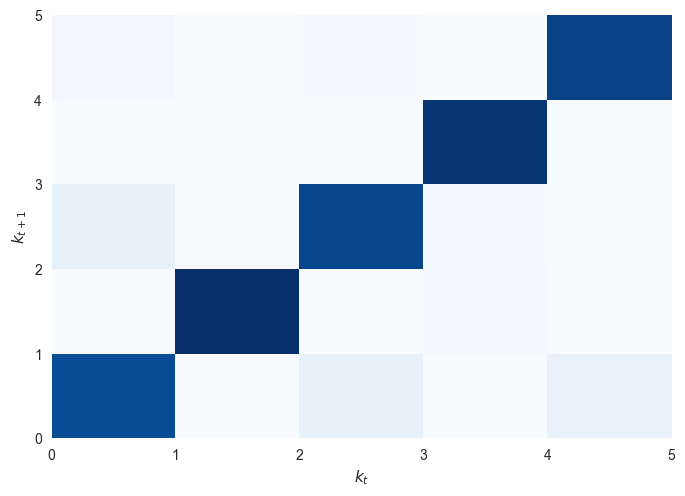

PyObject <matplotlib.text.Text object at 0x000000002BFA68D0>

In [53]:
pcolor(A, cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel(L"k_t")
ylabel(L"k_{t+1}")

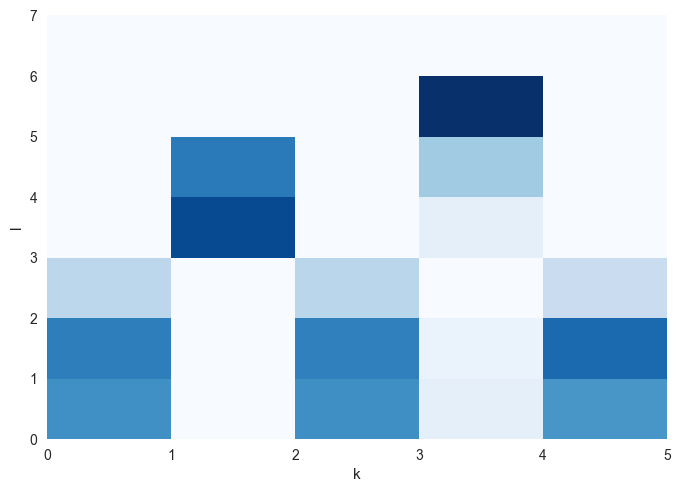

PyObject <matplotlib.text.Text object at 0x00000000022A4CC0>

In [54]:
pcolor(bΔ, cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel("k")
ylabel("l")

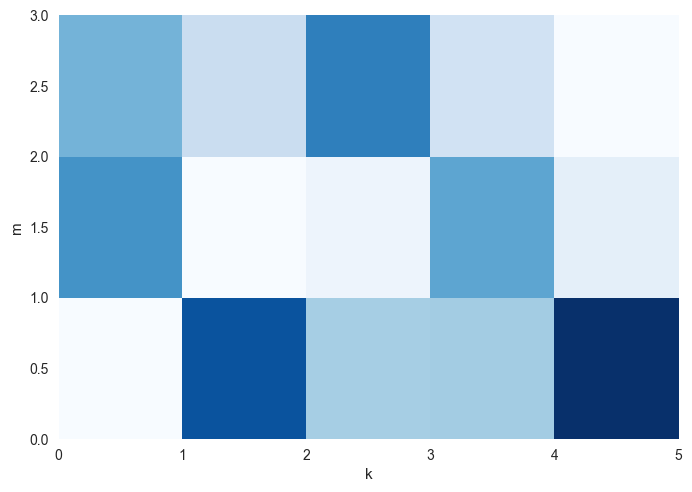

PyObject <matplotlib.text.Text object at 0x000000002C9814E0>

In [55]:
pcolor(c, cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel("k")
ylabel("m")

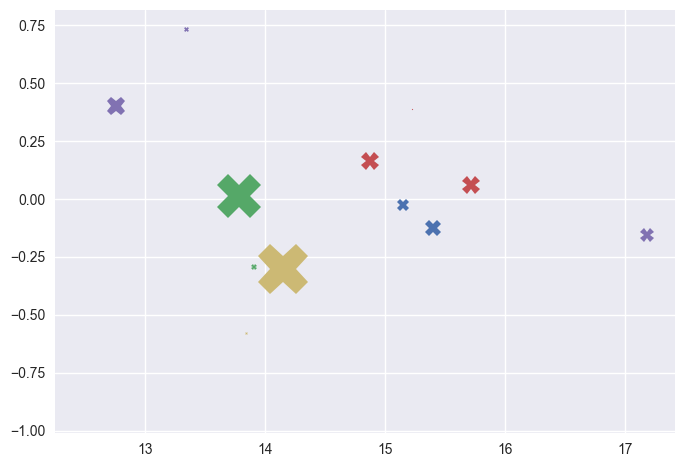

In [61]:
fig = figure()
ax = fig[:gca]()

for k in 1:K
    clr=0
    for m in 1:M
        if m == 1
            l = plot(μs[1, m, k], μs[2, m, k], "X", markersize=40*c[m, k], label=k)
            clr = l[1][:get_color]()
        else
            plot(μs[1, m, k], μs[2, m, k], "X", markersize=20*c[m, k], c=clr)
        end
    end
end